In [1]:
%matplotlib notebook
import os
import h5py
import psana
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
from scipy.sparse import coo_matrix

def moving_avg(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')

def get_first_moment(spectrum, a, b):
    xaxis = np.arange(a, b)
    return np.sum(xaxis*spectrum[a:b]) / np.sum(spectrum[a:b])

def polyfit2d(x, y, f, deg):
    deg = np.asarray(deg)
    vander = polynomial.polyvander2d(x, y, deg)
    vander = vander.reshape((-1, vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

def remove_background(img, a, b, c, d):
    x = np.arange(img.shape[0])
    y = np.concatenate((np.arange(a, b), np.arange(c, d)))
    X, Y = np.meshgrid(x, y)
    fit_img = np.concatenate((img[:, a:b], img[:, c:d]), axis=1)
    coeff = polyfit2d(X, Y, fit_img, [2, 2])
    
    img_corrected = np.copy(img)
    x = np.arange(img.shape[0])
    y = np.arange(a, d)
    X, Y = np.meshgrid(x, y)
    background = polynomial.polyval2d(X, Y, coeff).T
    img_corrected[:, a:d] -= background
    return img_corrected

def interpolate_epix_gap(spectrum):
    a, b  = 309, 349
    c, d = 361, 401
    xaxis = np.arange(spectrum.shape[0])
    x = np.concatenate((xaxis[a:b], xaxis[c:d]))
    y = np.concatenate((spectrum[a:b], spectrum[c:d]))
    poly = np.poly1d(np.polyfit(x, y, 2))
    spectrum[b:c] = poly(xaxis[b:c])
    
def load_runs(runs):
    x = np.array([], np.float32)
    y = np.array([], np.float32)
    adu = np.array([], np.float32)
    gmd = np.array([], np.float32)
    time = np.array([], np.int64)
    npix = np.array([], np.int32)
    ndroplets = np.array([], np.int32)
    for run in runs:
        fh = h5py.File('/reg/d/psdm/mfx/mfxlq3915/results/xes/data/run-%03d-new-gain.h5' %run, 'r')
        x = np.append(x, fh['x'].value)
        y = np.append(y, fh['y'].value)
        adu = np.append(adu, fh['adu'].value)
        gmd = np.append(gmd, fh['gmd'].value)
        time = np.append(time, fh['time'].value)
        npix = np.append(npix, fh['npix'].value)
        ndroplets = np.append(ndroplets, fh['ndroplets'].value)
        print '%e droplets in %d shots in run %d' %(fh['adu'].shape[0], fh['gmd'].shape[0], run)
        fh.close()
    index = np.empty(ndroplets.shape[0]+1, dtype=np.int64)
    index[0] = 0 
    index[1:] = np.cumsum(ndroplets)
    print '%e total droplets' %adu.shape[0]
    return x, y, adu, gmd, time, ndroplets, npix, index

def assemble_image(run, x, y, adu, low_lim, high_lim):
    ind, = np.where(((adu > low_lim) & (adu < high_lim)) | ((adu > 205) & (adu < 235)))
    img, xedges, yedges = np.histogram2d(x[ind], y[ind], bins=[np.arange(705), np.arange(769)], weights=adu[ind])
    
    ds = psana.DataSource('exp=mfxlq3915:run=%d:smd' %run)
    det = psana.Detector('Epix100a') 
    
    # interpolate missing pixels
    mask = det.mask(run, calib=True, status=True, edges=True, central=True, unbond=True, unbondnbrs=True)
    row, col = np.where(mask == 0)
    print row.shape[0], 'broken pixels'
    for i, j in zip(row, col):
        if i > 0 and i < img.shape[0]-1 and j > 0 and j < img.shape[1]-1:
            value = np.mean([img[i+1, j], img[i, j-1], img[i, j+1], img[i-1, j]])
            img[i, j] = value
            
    # geometry corrected image
    img = det.image(run, img)
    return img

def make_spectrum(runs, roi, adu_lim, plot=False, hit_finder=False):
    if hit_finder:
       x, y, adu, gmd, time, ndroplets, npix, index = crystal_hitfinder(runs)
    else:
        x, y, adu, gmd, time, ndroplets, npix, index = load_runs(runs)
        
    img = assemble_image(runs[0], x, y, adu, *adu_lim)
    spec = np.sum(img[:, roi[0]:roi[1]], axis=1)
    interpolate_epix_gap(spec)
    
    spec_corrected = np.sum(remove_background(img, 
                                              roi[0]-50, roi[0]-20, roi[1]+20, roi[1]+50)[:, roi[0]:roi[1]], axis=1)
    interpolate_epix_gap(spec_corrected)
    
    if plot:
        plot_summery(x, y, adu, ndroplets, gmd, time, index, roi)
        plt.figure()
        vmin, vmax = np.percentile(img, [1, 99])
        plt.imshow(img, origin='lower',vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.figure()
        plt.plot(np.sum(img, axis=0))

        plt.figure()
        plt.plot(spec / np.amax(spec), label='raw')
        plt.plot(spec_corrected / np.amax(spec_corrected), label='corrected')
        plt.ylim(0.0)
        plt.legend()
    return spec_corrected
    
def plot_summery(x, y, adu, ndroplets, gmd, time, index, roi):
    ind, = np.where((y > roi[0]) & (y < roi[1]))

    plt.figure()
    plt.hist(adu, bins=np.arange(30, 500))
    plt.hist(adu[ind], bins=np.arange(30, 300), label='ROI', alpha=0.5)
    plt.yscale('log')
    plt.legend()
    
    mask = (y > roi[0]) & (y < roi[1]) & (adu > 100.0) & (adu < 120.0)
    photon_per_shot_roi = np.add.reduceat(adu*mask, index[:-1])/110.0
    plt.figure()
    sort_ind = np.argsort(time)
    plt.plot(photon_per_shot_roi[sort_ind], 'o')
    plt.axhline(np.mean(photon_per_shot_roi), color='red')
    plt.ylabel('Mn K beta photons in ROI per shot')
    print 'total number of Mn K beta photon %.2e' %np.sum(photon_per_shot_roi)
    print photon_per_shot_roi.shape[0], 'shots'
    
    #plt.figure()
    #plt.hist(photon_per_shot_roi, bins=50)
    #plt.xlabel('Number of droplets in ROI')

    #plt.figure()
    #plt.hist(ndroplets, bins=50)
    #plt.xlabel('Number of droplets per image')

    #plt.figure()
    #plt.scatter(gmd, np.add.reduceat(adu, index[:-1]))
    #plt.xlabel('Pulse energy [mJ]')
    #plt.ylabel('Ingegrated ADU')

1.331070e+05 droplets in 450 shots in run 115
2.499760e+05 droplets in 498 shots in run 119
2.236260e+05 droplets in 496 shots in run 121
1.424730e+05 droplets in 498 shots in run 124
2.997010e+05 droplets in 493 shots in run 129
2.573730e+05 droplets in 492 shots in run 131
2.199710e+05 droplets in 462 shots in run 133
2.687010e+05 droplets in 485 shots in run 138
2.281870e+05 droplets in 485 shots in run 140
1.713230e+05 droplets in 494 shots in run 142
9.138790e+05 droplets in 2327 shots in run 146
5.085430e+05 droplets in 2231 shots in run 151
2.727970e+05 droplets in 482 shots in run 154
2.960320e+05 droplets in 490 shots in run 156
2.633890e+05 droplets in 493 shots in run 158
2.452470e+05 droplets in 493 shots in run 160
2.534480e+05 droplets in 487 shots in run 162
2.888720e+05 droplets in 474 shots in run 164
2.300510e+05 droplets in 493 shots in run 166
2.388060e+05 droplets in 465 shots in run 169
5.573100e+04 droplets in 207 shots in run 171
2.714880e+05 droplets in 494 sho

<IPython.core.display.Javascript object>


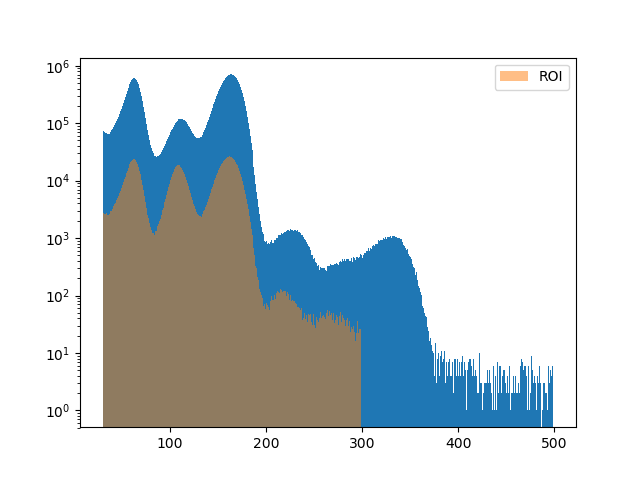

<IPython.core.display.Javascript object>


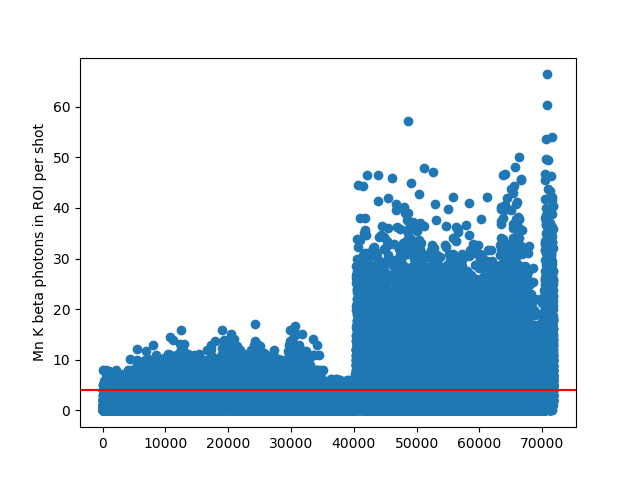

total number of Mn K beta photon 2.88e+05
71778 shots


<IPython.core.display.Javascript object>


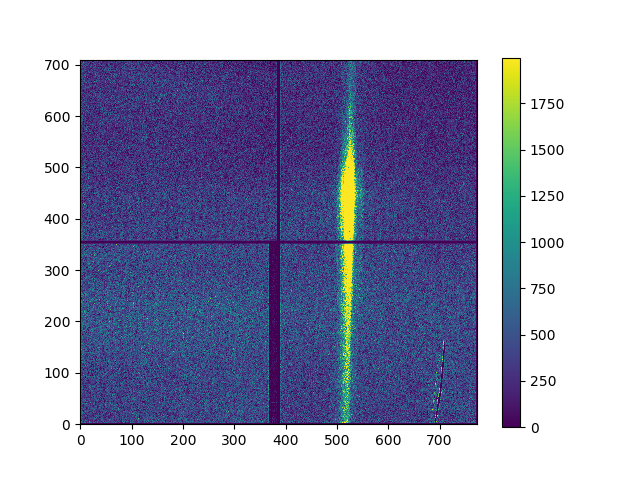

<IPython.core.display.Javascript object>


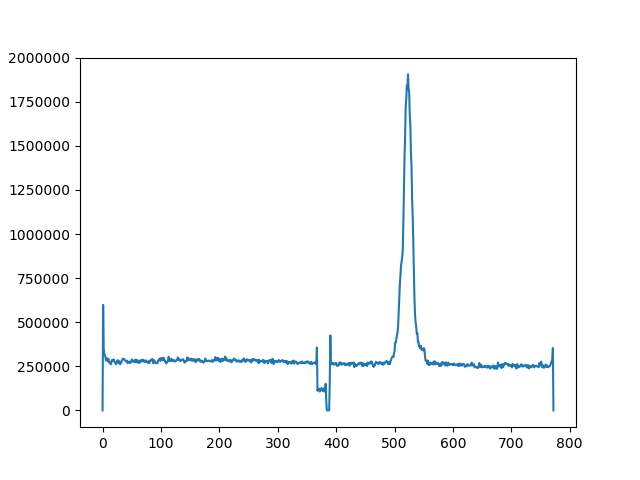

<IPython.core.display.Javascript object>


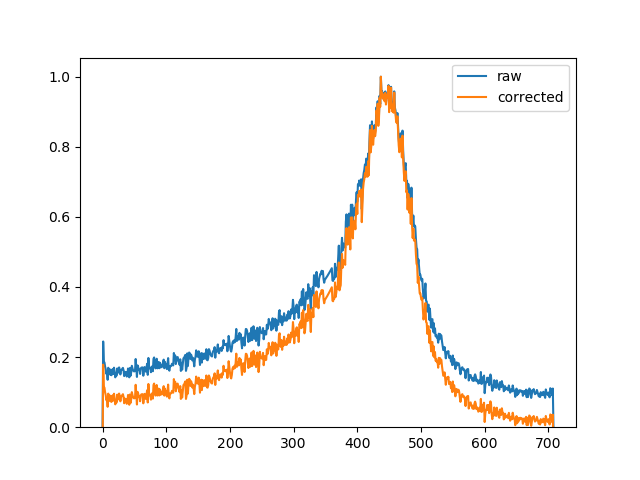

In [9]:
# 0F
runs = [115, 119, 121, 124, 129, 131, 133, 138, 140, 142, 146, 
        151, 154, 156, 158, 160, 162, 164, 166, 169, 171, 173,
        175, 177, 179, 182, 185, 187, 189, 191, 193]
spectrum_0F = make_spectrum(runs, (510, 540), (100, 120), plot=False)

# 2F
runs = [137, 139, 176, 178, 184, 186]
spectrum_2F = make_spectrum(runs, (510, 540), (100, 120), plot=False)

# 2F150us
runs = [114, 116, 118, 120, 122, 123, 125, 128, 130, 132, 
        134, 141, 143, 145, 147, 148, 149, 153, 155, 157, 
        159, 161, 163, 165, 167, 188, 190, 192]
spectrum_2F150us = make_spectrum(runs, (510, 540), (100, 120), plot=True)

## Check Epix gain

2.125913e+06 droplets in 2835 shots in run 246
1.736726e+06 droplets in 2936 shots in run 247
1.947334e+06 droplets in 2991 shots in run 248
1.729107e+06 droplets in 2864 shots in run 249
1.623104e+06 droplets in 2788 shots in run 250
2.291600e+04 droplets in 125 shots in run 251
3.653750e+05 droplets in 866 shots in run 252
3.824920e+05 droplets in 558 shots in run 253
4.993950e+05 droplets in 859 shots in run 254
1.559217e+06 droplets in 2715 shots in run 255
2.951740e+05 droplets in 494 shots in run 256
1.728061e+06 droplets in 2929 shots in run 257
2.706070e+05 droplets in 483 shots in run 258
1.598215e+06 droplets in 2948 shots in run 259
1.986650e+05 droplets in 459 shots in run 260
1.311364e+06 droplets in 2777 shots in run 261
2.254460e+05 droplets in 472 shots in run 262
1.897714e+06 droplets in 3503 shots in run 263
1.411324e+06 droplets in 2831 shots in run 264
1.900000e+01 droplets in 19 shots in run 265
1.405843e+06 droplets in 2921 shots in run 266
1.564445e+06 droplets i

<IPython.core.display.Javascript object>


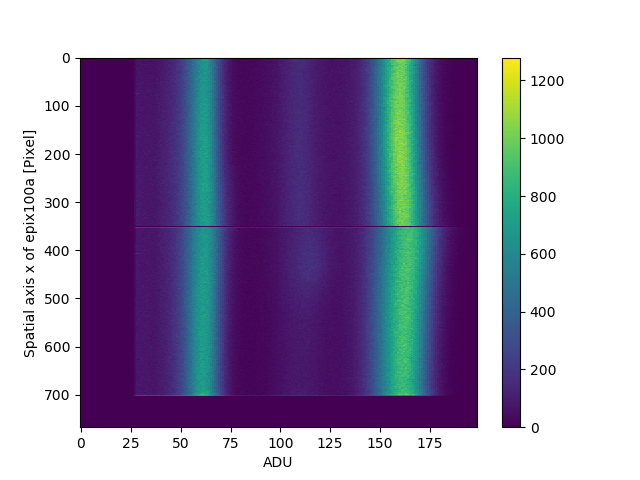

<IPython.core.display.Javascript object>


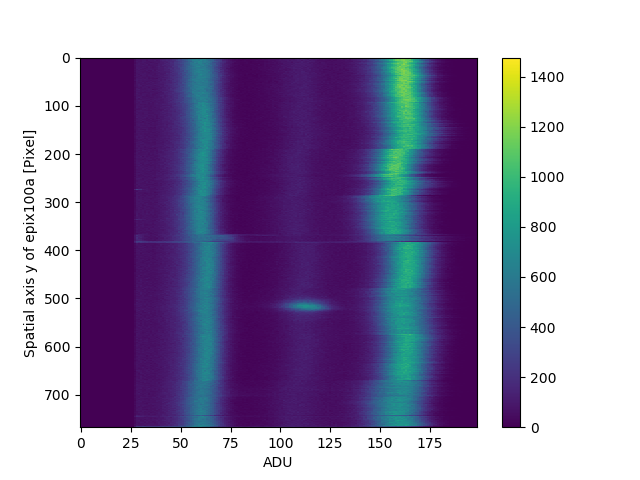

In [3]:
runs = np.arange(246, 271)
x, y, adu, gmd, time, ndroplets, npix, index = load_runs(runs)

img, xedges, yedges = np.histogram2d(x, adu, bins=[np.arange(769), np.arange(0, 200)])
plt.figure()
plt.imshow(img, aspect='auto')
plt.colorbar()
plt.xlabel('ADU')
plt.ylabel('Spatial axis x of epix100a [Pixel]')
#plt.title('Old gain file')
#plt.title('New gain file from Philip')

img, xedges, yedges = np.histogram2d(y, adu, bins=[np.arange(769), np.arange(0, 200)])
plt.figure()
plt.imshow(img, aspect='auto')
plt.colorbar()
plt.xlabel('ADU')
plt.ylabel('Spatial axis y of epix100a [Pixel]')
#plt.title('Old gain file')
#plt.title('New gain file from Philip')

In [2]:
import pywt
from statsmodels.robust.scale import mad
def waveletSmooth(x, wavelet="db4", level=1):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec(coeff, wavelet, mode="per" )
    return y

<IPython.core.display.Javascript object>


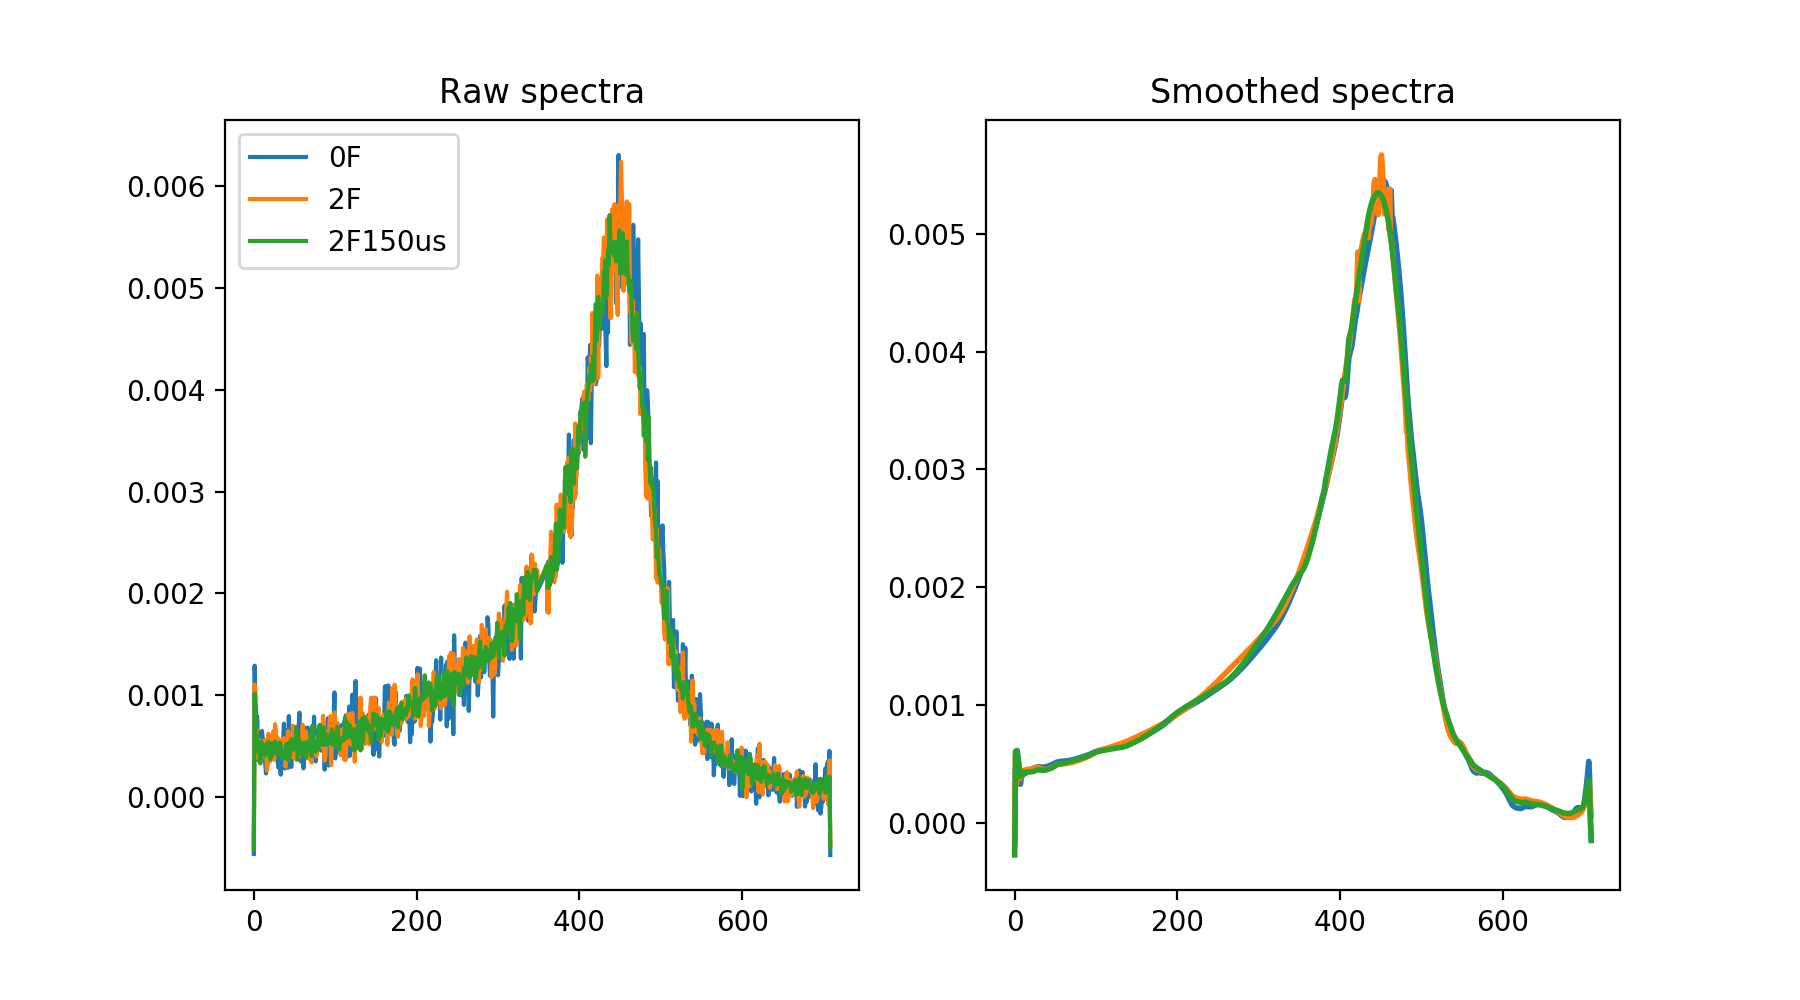

<IPython.core.display.Javascript object>


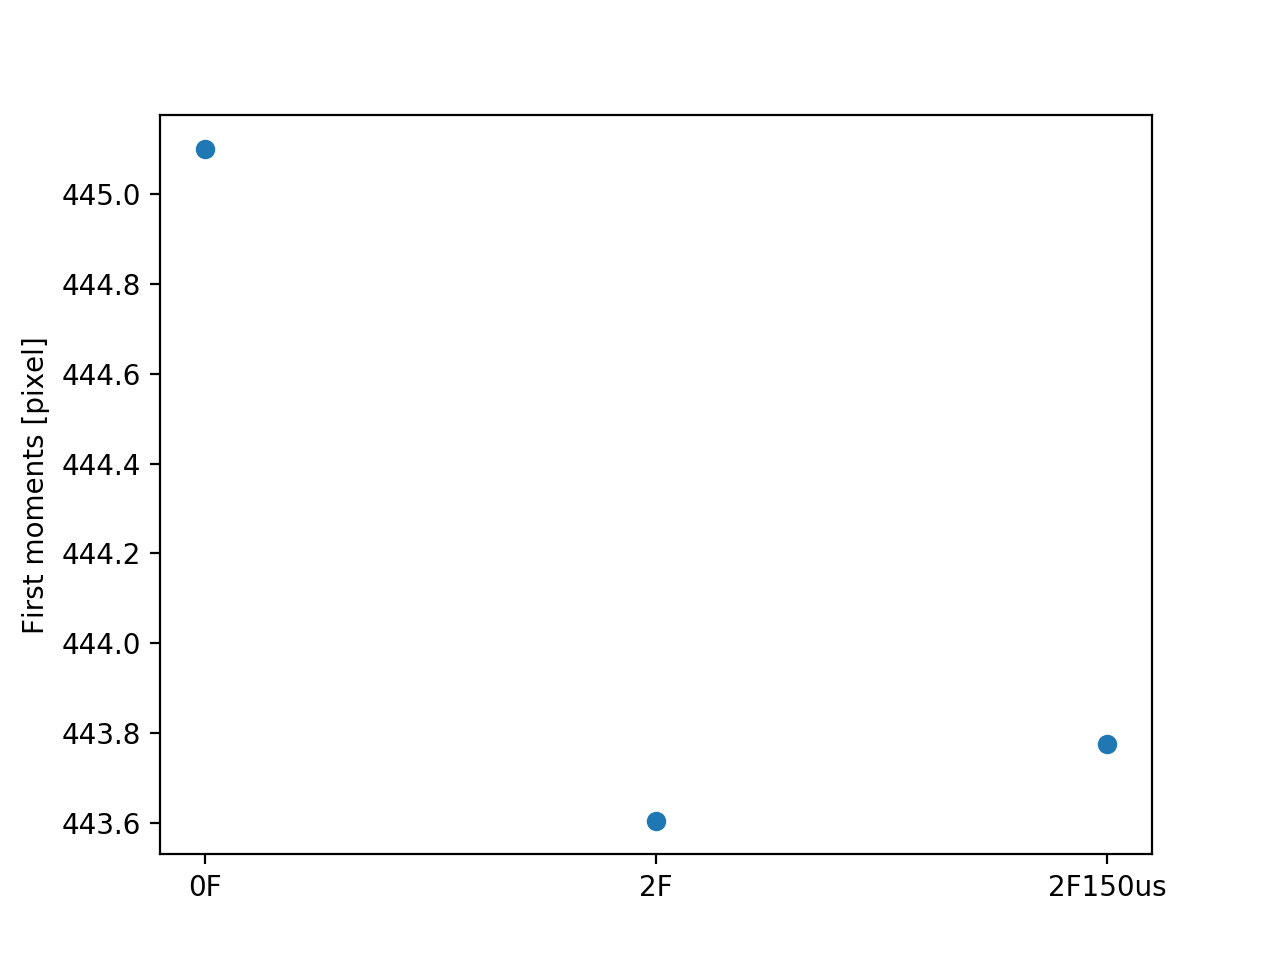

In [3]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

spectrum = spectrum_0F / np.sum(spectrum_0F)
l, = ax1.plot(spectrum, label='0F')
ax2.plot(waveletSmooth(spectrum), linewidth=2.0, color=l.get_color())

spectrum = spectrum_2F / np.sum(spectrum_2F)
l, = ax1.plot(spectrum, label='2F')
ax2.plot(waveletSmooth(spectrum), linewidth=2.0, color=l.get_color())

spectrum = spectrum_2F150us / np.sum(spectrum_2F150us)
l, = ax1.plot(spectrum, label='2F150us')
ax2.plot(waveletSmooth(spectrum), linewidth=2.0, color=l.get_color())

ax1.legend()
ax1.set_title('Raw spectra')
ax2.set_title('Smoothed spectra')

moments = []
moments.append(get_first_moment(spectrum_0F, 350, 600))
moments.append(get_first_moment(spectrum_2F, 350, 600))
moments.append(get_first_moment(spectrum_2F150us, 350, 600))

x = np.arange(len(moments))
plt.figure()
plt.plot(x, moments, 'o')
plt.xticks(x, ['0F', '2F', '2F150us'])
plt.ylabel('First moments [pixel]')